# Mesoscopic Whole-Brain Modelling of Neural Dynamics: An Introduction

***Dr. John D. Griffiths***

*KCNI School 2020*

---

## Contents


[Overview](#Overview)  
[Setup](#Setup)  
[Neural mass model of local neural dynamics](#Neural-mass-model-of-local-neural-dynamics)  
[Network model of whole-brain anatomical connectivity](#Network-model-of-whole-brain-anatomical-connectivity)  
[Conclusions](#Conclusions)  
[References](#References)  


---

## Overview


In this tutorial we will cover some of the key components involved in computational modelling of mesoscopic, whole-brain network dynamics.

The paradigm we use for mathematically and computationally describing brain organization is called <b>connectome-based neural mass modelling</b>. 
Within this framework, the two main components of setting up a whole brain model are 

1) **node-level dynamics** and   
2) the large-scale **network topology**.  

We will examine each of these in term, for an exemplary neural mass model and brain network connectivity. 

This focus is on **resting** or 'steady-state' (as opposed to task- or stimulus-evoked) neural activity, at the relatively **fast timescales** measured by EEG, MEG, ECoG, LFP, etc. (as opposed to slower timescale signals seen in functional MRI). 

Demonstrations are done using a combination of pure-python code and simulations run using the **The Virtual Brain (TVB)** software library. 



---

## Setup

If you are running this notebook in Google Colab, you will need to install some packages. If you are running in a more standard python environment, you need to ensure that these packages are installed externally (typically with `pip install <package>` on the command line).  

In [1]:
# If running in google colab, uncomment the install commands and execute this cell:

# TVB scientific library
#!pip install tvb-library

# TVB datasets
#!pip install tvb-data

# Neuroimaging library; we are just using this for visualization
#!pip install nilearn

Now import the libraries that are needed for the tutorial:

In [2]:
# Suppress warnings; keeps things cleaner
import warnings
warnings.filterwarnings('ignore')


# Standard scientific python import commands
import os,sys,glob,numpy as np,pandas as pd,seaborn as sns
sns.set_style('white')

%matplotlib inline
from matplotlib import pyplot as plt


# Some more matplotlib viz things
from matplotlib.pyplot import subplot
from numpy import exp,sin,cos,pi,tan,tanh
from matplotlib.tri import Triangulation


# Some nilearn viz tools
from nilearn.plotting import plot_surf_roi,plot_surf_stat_map,plot_surf


# TVB stuff
from tvb.simulator.lab import (models,connectivity,coupling,integrators,noise,simulator,
                              surfaces,region_mapping,monitors)

# For power spectrum calculations
from scipy.signal import welch


C:\Users\john_griffiths\Software\miniconda2\envs\jupyter_py3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


2020-07-05 20:41:44,843 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


In [3]:
from IPython.display import clear_output
from fooof import FOOOF
from fooof import FOOOF,FOOOFGroup

Some custom surface visualization functions (slightly better alternatives to `nilearn` functions, which we will also use)

In [4]:
def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient='tvb',view='superior',
                     shaded=False,ax=None,figsize=(6,4), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):
                        
  r"""Plot surfaces, surface patterns, and region patterns with matplotlib
    
  This is a general-use function for neuroimaging surface-based data, and 
  does not necessarily require construction of or interaction with tvb 
  datatypes. 

  See also:  plot_surface_mpl_mv



  Parameters
  ----------
  
  vtx           : N vertices x 3 array of surface vertex xyz coordinates 

  tri           : N faces x 3 array of surface faces

  data          : array of numbers to colour surface with. Can be either 
                  a pattern across surface vertices (N vertices x 1 array),
                  or a pattern across the surface's region mapping 
                  (N regions x 1 array), in which case the region mapping 
                  bust also be given as an argument. 
                  
  rm            : region mapping - N vertices x 1 array with (up to) N 
                  regions unique values; each element specifies which 
                  region the corresponding surface vertex is mapped to 

  reorient      : modify the vertex coordinate frame and/or orientation 
                  so that the same default rotations can subsequently be 
                  used for image views. The standard coordinate frame is 
                  xyz; i.e. first,second,third axis = left-right, 
                  front-back, and up-down, respectively. The standard 
                  starting orientation is axial view; i.e. looking down on
                  the brain in the x-y plane.
                  
                  Options: 

                    tvb (default)   : swaps the first 2 axes and applies a rotation
                                              
                    fs              : for the standard freesurfer (RAS) orientation; 
                                      e.g. fsaverage lh.orig. 
                                      No transformations needed for this; so is 
                                      gives same result as reorient=None

  view          : specify viewing angle. 
  
                  This can be done in one of two ways: by specifying a string 
                  corresponding to a standard viewing angle, or by providing 
                  a tuple or list of tuples detailing exact rotations to apply 
                  around each axis. 
                  
                  Standard view options are:
    
                  lh_lat / lh_med / rh_lat / rh_med / 
                  superior / inferior / posterior / anterior

                  (Note: if the surface contains both hemispheres, then medial 
                   surfaces will not be visible, so e.g. 'rh_med' will look the 
                   same as 'lh_lat')
                   
                  Arbitrary rotations can be specied by a tuple or a list of 
                  tuples, each with two elements, the first defining the axis 
                  to rotate around [0,1,2], the second specifying the angle in 
                  degrees. When a list is given the rotations are applied 
                  sequentially in the order given. 
                  
                  Example: rotations = [(0,45),(1,-45)] applies 45 degrees 
                  rotation around the first axis, followed by 45 degrees rotate 
                  around the second axis. 

  lthr/uthr     : lower/upper thresholds - set to zero any datapoints below / 
                  above these values
  
  nz_thr        : near-zero threshold - set to zero all datapoints with absolute 
                  values smaller than this number. Default is a very small 
                  number (1E-20), which unless your data has very small numbers, 
                  will only mask out actual zeros. 

  shade_kwargs  : dictionary specifiying shading options

                  Most relevant options (see matplotlib 'tripcolor' for full details):
                  
                    - 'shading'        (either 'gourand' or omit; 
                                        default is 'flat')
                    - 'edgecolors'     'k' = black is probably best
                    - 'linewidth'      0.1 works well; note that the visual 
                                       effect of this will depend on both the 
                                       surface density and the figure size 
                    - 'cmap'           colormap
                    - 'vmin'/'vmax'    scale colormap to these values
                    - 'alpha'          surface opacity
                  
  ax            : figure axis
  
  figsize       : figure size (ignore if ax provided)
  
  title         : text string to place above figure
  
  
  
                  
  Usage
  -----
       

  Basic freesurfer example:

  import nibabel as nib
  vtx,tri = nib.freesurfer.read_geometry('subjects/fsaverage/surf/lh.orig')
  plot_surface_mpl(vtx,tri,view='lh_lat',reorient='fs')



  Basic tvb example:
  
  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat,view='inferior',title='inferior')

  fig, ax = plt.subplots()
  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat, view=[(0,-90),(1,55)],ax=ax,
                   title='lh angle',shade_kwargs={'shading': 'gouraud', 'cmap': 'rainbow'})

   
  """
    
  # Copy things to make sure we don't modify things 
  # in the namespace inadvertently. 
    
  vtx,tri = vtx.copy(),tri.copy()
  if data is not None: data = data.copy()

  # 1. Set the viewing angle 
  
  if reorient == 'tvb':
    # The tvb default brain has coordinates in the order 
    # yxz for some reason. So first change that:   
    vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()
    
    # Also need to reflect in the x axis
    vtx[:,0]*=-1

  # (reorient == 'fs' is same as reorient=None; so not strictly needed
  #  but is included for clarity)
   


  # ...get rotations for standard view options
    
  if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ] 
  elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'superior'  : rots =   None
  elif view == 'inferior'  : rots =   (1,180)
  elif view == 'anterior'  : rots =   (0,-90)
  elif view == 'posterior' : rots =  [(0, -90),(1,180)]
  elif (type(view) == tuple) or (type(view) == list): rots = view 

  # (rh_lat is the default 'view' argument because no rotations are 
  #  for that one; so if no view is specified when the function is called, 
  #  the 'rh_lat' option is chose here and the surface is shown 'as is' 
                            
                            
  # ...apply rotations                          
     
  if rots is None: rotmat = np.eye(3)
  else:            rotmat = get_combined_rotation_matrix(rots)
  vtx = np.dot(vtx,rotmat)

                                    
      
  # 2. Sort out the data
                                    
                                    
  # ...if no data is given, plot a vector of 1s. 
  #    if using region data, create corresponding surface vector 
  if data is None: 
    data = np.ones(vtx.shape[0]) 
  elif data.shape[0] != vtx.shape[0]: 
    data = np.array([data[r] for r in rm])
    
  # ...apply thresholds
  if uthr: data *= (data < uthr)
  if lthr: data *= (data > lthr)
  data *= (np.abs(data) > nz_thr)

                                    
  # 3. Create the surface triangulation object 
  
  x,y,z = vtx.T
  tx,ty,tz = vtx[tri].mean(axis=1).T
  tr = Triangulation(x,y,tri[np.argsort(tz)])
                
  # 4. Make the figure 

  if ax is None: fig, ax = plt.subplots(figsize=figsize)  
  
  #if shade = 'gouraud': shade_opts['shade'] = 
  tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)
                        
  ax.set_aspect('equal')
  ax.axis('off')
    
  if title is not None: ax.set_title(title)






def plot_surface_mpl_mv(vtx=None,tri=None,data=None,rm=None,hemi=None,   # Option 1
                        vtx_lh=None,tri_lh=None,data_lh=None,rm_lh=None, # Option 2
                        vtx_rh=None,tri_rh=None,data_rh=None,rm_rh=None,
                        title=None,**kwargs):

  r"""Convenience wrapper on plot_surface_mpl for multiple views 
   
  This function calls plot_surface_mpl five times to give a complete 
  picture of a surface- or region-based spatial pattern. 

  As with plot_surface_mpl, this function is written so as to be 
  generally usable with neuroimaging surface-based data, and does not 
  require construction of of interaction with tvb datatype objects. 

  In order for the medial surfaces to be displayed properly, it is 
  necessary to separate the left and right hemispheres. This can be 
  done in one of two ways: 

  1. Provide single arrays for vertices, faces, data, and 
     region mappings, and addition provide arrays of indices for 
     each of these (vtx_inds,tr_inds,rm_inds) with 0/False 
     indicating left hemisphere vertices/faces/regions, and 1/True 
     indicating right hemisphere. 

     Note: this requires that 

  2. Provide separate vertices,faces,data,and region mappings for 
     each hemisphere (vtx_lh,tri_lh; vtx_rh,tri_rh,etc...)


 
  Parameters
  ----------

  (see also plot_surface_mpl parameters info for more details)

  (Option 1)

  vtx               :  surface vertices
 
  tri               : surface faces

  data              : spatial pattern to plot

  rm                : surface vertex to region mapping

  hemi              : hemisphere labels for each vertex
                      (1/True = right, 0/False = left) - 
      

  OR

  (Option 2)

  vtx_lh            : left hemisphere surface_vertices
  vtx_rh            : right ``      ``    ``     ``
  
  tri_lh            : left hemisphere surface faces 
  tri_rh            : right ``      ``    ``     ``

  data_lh          : left hemisphere surface_vertices
  data_rh          : right ``      ``    ``     ``

  rm_lh            : left hemisphere region_mapping
  rm_rh            : right ``      ``    ``     ``


  title            : title to show above middle plot
 
  kwargs           : additional tripcolor kwargs; see plot_surface_mpl

 

  Examples
  ----------

  # TVB default data

  # Plot one column of the region-based tract lengths 
  # connectivity matrix. The corresponding region is 
  # right auditory cortex ('rA1')

  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                      hemi=isrh_vtx,title=u'rA1 \ntract length')

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                    hemi=isrh_vtx,title=u'rA1 \ntract length',
                    shade_kwargs = {'shading': 'gouraud',
                                    'cmap': 'rainbow'}) 


  """
   

 
  if vtx is not None:                                    # Option 1
    tri_hemi = hemi[tri].any(axis=1)
    tri_lh,tri_rh = tri[tri_hemi==0],tri[tri_hemi==1]
  elif vtx_lh is not None:                               # Option 2
    vtx = np.vstack([vtx_lh,vtx_rh])
    tri = np.vstack([tri_lh,tri_rh+tri_lh.max()+1])

  if data_lh is not None:                                # Option 2
    data = np.hstack([data_lh,data_rh])
    
  if rm_lh is not None:                                  # Option 2 
    rm = np.hstack([rm_lh,rm_rh + rm_lh.max() + 1])
    
 

  # 2. Now do the plots for each view

  # (Note: for the single hemispheres we only need lh/rh arrays for the 
  #  faces (tri); the full vertices, region mapping, and data arrays
  #  can be given as arguments, they just won't be shown if they aren't 
  #  connected by the faces in tri )
  
  # LH lateral
  plot_surface_mpl(vtx,tri_lh,data=data,rm=rm,view='lh_lat',
                   ax=subplot(2,3,1),**kwargs)
    
  # LH medial
  plot_surface_mpl(vtx,tri_lh, data=data,rm=rm,view='lh_med',
                   ax=subplot(2,3,4),**kwargs)
    
  # RH lateral
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_lat',
                   ax=subplot(2,3,3),**kwargs)
    
  # RH medial
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_med',
                   ax=subplot(2,3,6),**kwargs)
    
  # Both superior
  plot_surface_mpl(vtx,tri, data=data,rm=rm,view='superior',
                   ax=subplot(1,3,2),title=title,**kwargs)
    
  plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0,
                      top=1.0, wspace=0, hspace=0) 




def get_rotation_matrix(rotation_axis, deg):
    
  '''Return rotation matrix in the x,y,or z plane'''
   
  
 
  # (note make deg minus to change from anticlockwise to clockwise rotation)
  th = -deg * (pi/180) # convert degrees to radians
    
  if rotation_axis == 0:
    return np.array( [[    1,         0,         0    ],
                      [    0,      cos(th),   -sin(th)],
                      [    0,      sin(th),    cos(th)]])
  elif rotation_axis ==1:
    return np.array( [[   cos(th),    0,        sin(th)],
                      [    0,         1,          0    ],
                      [  -sin(th),    0,        cos(th)]])
  elif rotation_axis ==2:
    return np.array([[   cos(th),  -sin(th),     0    ],
                     [    sin(th),   cos(th),     0   ],
                     [     0,         0,          1   ]])
    


def get_combined_rotation_matrix(rotations):
  '''Return a combined rotation matrix from a dictionary of rotations around 
     the x,y,or z axes'''
  rotmat = np.eye(3)
    
  if type(rotations) is tuple: rotations = [rotations] 
  for r in rotations:
    newrot = get_rotation_matrix(r[0],r[1])
    rotmat = np.dot(rotmat,newrot)
  return rotmat

---

## Neural mass model of local neural dynamics

Connectome-based neural mass models model large-scale brain activity measurements using a set of neural masses interconnected by an anatomical connectome. 

We'll start by looking at the individual components - the neural masses. 

A **neural mass model** is a mathematical description of **neural population** activity. Specifically, they aim to describe the *average* activity within a population of thousands or tens of thousands of cells, as opposed to the activity of each cell individually. 

There are a variety of neural mass models currently in use in the field, which vary in things like the level of physiological detail (e.g. number of subpopulations), and the exact quantities they aim to describe (e.g. activity-based vs. voltage-based vs. conductance-based). We will not go into the nuances of such model formulation choices here; see e.g. Deco et al. (2008), Liley et al. (2012), Moran et al. (2013), of Freeman (1975) for excellent treatments of the topic. 

Here we will focus our attention on a single, widely used neural mass model: the *Jansen-Rit model* (Jansen & Rit 1993, 1995; David & Friston 2006; Spiegler et al. 2011). 

### Jansen-Rit model - overview and architecture

The paper by Jansen & Rit (1995) has been very influential. 

---


<img src="https://github.com/GriffithsLab/LabNotebook/raw/master/site/static/img/jansen_rit_1995_abstract_pic.png" width="900" >

---


The model proposed here extends earlier formulations, most notably that of Lopes Da Silva et al. (1974), and has been subsequently explored and developed by multiple groups, including David & Friston (2006) and Spiegler et al. (2010).

The model is a simplified description of a cortical column, in terms of three neural populations: Pyramidal Neurons (PN), excitatory interneurons (EIN), and inhibitory interneurons (IIN). The schematic on the left hand side of the figure below shows how these three populations are wired: The PN population sends excitatory projections to both the EIN and IIN populations. The EIN and IIN populations send excitatory and inhibitory projects, respectively, to the PN population. 

<br>

<img src="https://github.com/GriffithsLab/LabNotebook/raw/master/site/static/img/JansenRit_diagram.jpg" width="900" >

On the right hand side of this figure is an equivalent current circuit diagram. This shows the projections between populations as sketched on the left hand diagram, but additionally depicts the two key mathematical operations that are applied to neural activity inputs/outputs as they flow through this circuit between the populations:

$h_{e,i}(t)$ - *wave-to-pulse* conversion: acting at the *dendrites*, converts incoming firing rates into population-average membrane potential

$S(V)$ - *pulse-to-wave* conversion: acting at the *axon hillock*, converts population-average somatic membrane potential into population-average firing rates


The equations describing this system are given below. Before jumping in running simulations, we will take a bit of time to look at these equations and what the model components are doing. 

\begin{align}
            \dot{y_0} &= y_3 \\
            \dot{y_3} &= A a\,S[y_1 - y_2] - 2a\,y_3 - 2a^2\, y_0 \\
            \dot{y_1} &= y_4\\
            \dot{y_4} &= A a \,[p(t) + \alpha_2 J S[\alpha_1 J\,y_0]+ c_0]
                        -2a\,y - a^2\,y_1 \\
            \dot{y_2} &= y_5 \\
            \dot{y_5} &= B b (\alpha_4 J\, S[\alpha_3 J \,y_0]) - 2 b\, y_5
                        - b^2\,y_2 \\
            S[v] &= \frac{2\, \nu_{max}}{1 + \exp^{r(v_0 - v)}}
\end{align}

$A$ - Maximum amplitude of EPSP [mV]. Also called average synaptic gain.

$B$ - Maximum amplitude of IPSP [mV]. Also called average synaptic gain

$b$ - Reciprocal of the time constant of passive membrane and all other spatially distributed delays in the dendritic network [ms^-1]. Also called average synaptic time constant

$v0$ - Firing threshold (PSP) for which a 50% firing rate is achieved. In other words, it is the value of the average membrane potential corresponding to the inflection point of the sigmoid [mV]

$nu_max$ - Determines the maximum firing rate of the neural population [s^-1]

$r$ - Steepness of the sigmoidal transformation [mV^-1]

$J$ - Average number of synapses between populations

$a_1$ - Average probability of synaptic contacts in the feedback excitatory loop

$a_2$ - Average probability of synaptic contacts in the slow feedback excitatory loop.

$a_3$ - Average probability of synaptic contacts in the feedback inhibitory loop

$a_4$ - Average probability of synaptic contacts in the slow feedback inhibitory loop

$p_min$ - Minimum input firing rate

$p_max$ - Maximum input firing rate

$\mu$ - Mean input firing rate

### Initializing a model

Models of 'local' neural dynamics are initialized in TVB like so

In [5]:
jrm_mod = models.JansenRit()

The model parameters can be expected through the command line outputs

In [6]:
jrm_mod

,value
"A [min, median, max]","[3.25, 3.25, 3.25]"
A dtype,float64
A shape,"(1,)"
"B [min, median, max]","[22, 22, 22]"
B dtype,float64
B shape,"(1,)"
"J [min, median, max]","[135, 135, 135]"
J dtype,float64
J shape,"(1,)"
Type,JansenRit


### Running a single-node simulation

Before we get to the whole-brain network models, TVB has some useful functionality (the `stationary_trajectory` method) for simulating and exploring the dynamics of individual network nodes / neural mass models. 

Here is a simple function that calls this method, organizes the results into a `pandas` dataframe, and also calculates the power spectrum of the generated time series:

In [7]:
def jrm_singlenode(jrm_params={},n_step=5000,dt=0.5):

  colnames = ['cPN', 'cEIN', 'cIIN', 'vPN', 'vEIN', 'vIIN']

  # Define initial conditions
  #initconds = np.array([2.,0.])[:,np.newaxis]

  # Initialize model instance with fixed params
  mod = models.JansenRit(**jrm_params)
  
  # Define initial conditions
  #initconds = np.array([2.,0.])[:,np.newaxis]

  # Execute single-node simulation run
  time,dat = mod.stationary_trajectory(n_step=n_step,dt=dt) # initial_conditions=initconds)
    
  # Output from TVB sims is always a 4D array. 
  # Reorganize into a 2D pandas dataframe    
  df_ys = pd.DataFrame(np.squeeze(dat),index=time,columns=colnames)
  

  #freqs,ps = welch(df.values.T,fs=1000/dt, noverlap = 0, nperseg=16000)
  per = np.unique(np.diff(time))[0]
  freqs,ps = welch(df_ys.values.T,fs=1000/per, noverlap = 0, nperseg=16000)

  df_ps = pd.DataFrame(ps.T,index=freqs,columns=df_ys.columns)

  return df_ys,df_ps

In [8]:
df_ys,df_ps = jrm_singlenode()

taking a look at the neural activity dataframe, we can see there are 6 columns, corresponding to each state variable in the Jansen-Rit model. 
These are the membrane potential (prefixed 'v') and current (prefixed 'c'), corresponding respectively to first and second-order terms, for the pyramidal (PN), excitatory interneuron (EIN), and inhibitory interneuron (IIN) populations.

In [9]:
df_ys.head()

,cPN,cEIN,cIIN,vPN,vEIN,vIIN
0.0,-0.953256,-87.113230,-0.733935,-3.612679,-1.152451,-299.824365
5.0,-2.759596,-87.689456,-150.646118,-3.246645,-0.565890,-284.832230
10.0,-12.738872,-81.303400,-1280.906166,-0.828706,2.828132,-162.925941
15.0,-14.239026,-64.772026,-1898.018238,0.171523,3.589478,-81.303592
20.0,-12.457991,-47.265449,-2174.989192,0.502474,3.284461,-28.043316


In general, for present purposes, we're only really interested in the currents (`cPN`, `cEIN`, `cIIN`).

Take a look at the time series

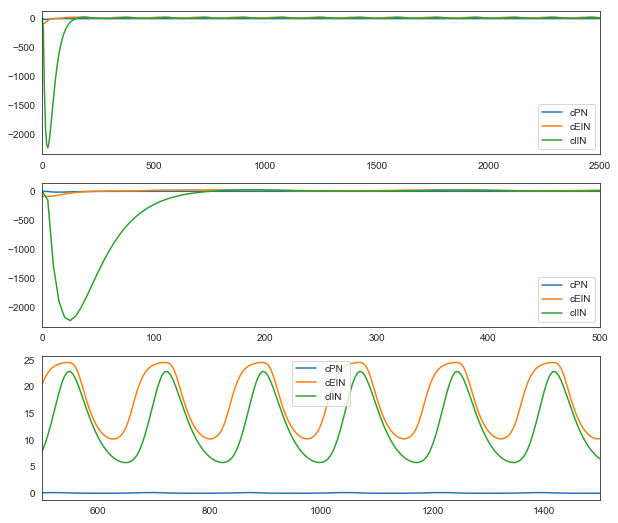

In [10]:
fig, ax = plt.subplots(nrows=3, figsize=(10,9))


df_ys[['cPN', 'cEIN', 'cIIN']].plot(ax=ax[0])

df_ys[['cPN', 'cEIN', 'cIIN']].loc[:500].plot(ax=ax[1])

df_ys[['cPN', 'cEIN', 'cIIN']].loc[500:1500].plot(ax=ax[2])


The above three plots show the full 2000ms simulated time series, the first 500ms, and 500-1500ms, respectively.

Note that in the first two, the y scale is dominated by the initial transient.

This raises an important general point when running numerical simulations of this kind (specifically, of steady-state behaviour): 

in these cases we generally want to ***ignore the transient***. Hence the third figure above ignores the first 500ms of simulation, and shows activity from 500ms-1500ms. 

FYI, all populations are oscillating here, just with different magnitudes. Plotting the pyramidal oscillation with separate magnitude (given by right-hand side y axis below) shows this:

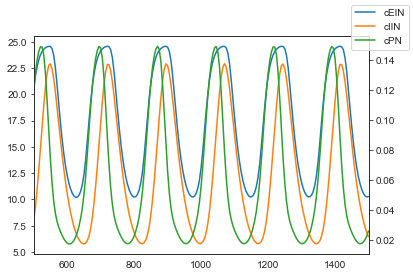

In [11]:
fig, ax = plt.subplots()

df_ys[['cEIN', 'cIIN']].loc[500:1500].plot(ax=ax,legend=False)
df_ys['cPN'].loc[500:1500].plot(ax=ax,secondary_y=True,legend=False)

fig.legend()

Normalizing the the time series by their means (excluding the transient) does a similar job. We will use this approach quite often. 

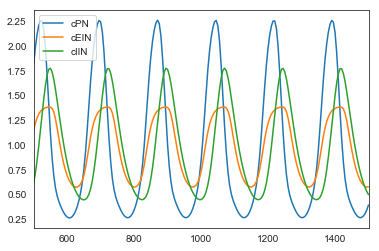

In [12]:
df_ys_norm = df_ys / df_ys.loc[500:1500].mean(axis=0)
df_ys_norm[['cPN', 'cEIN', 'cIIN']].loc[500:1500].plot()

### Oscillations are generated by negative feedback loops

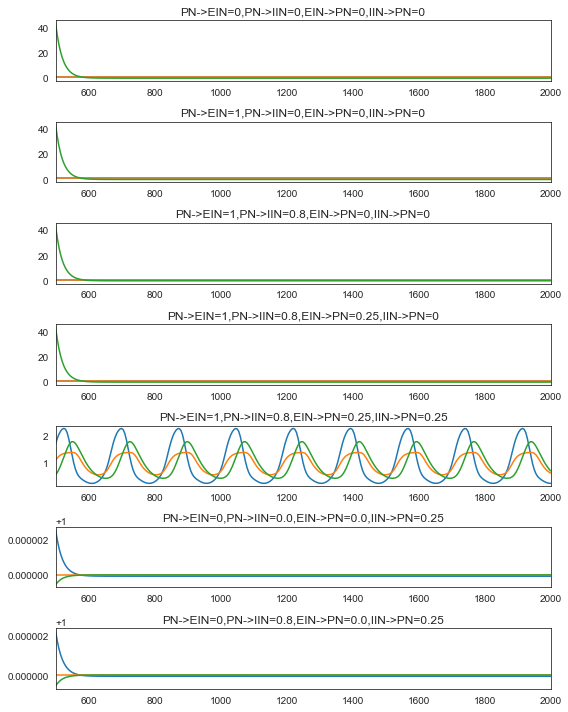

In [13]:
params =  [[0, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0.8, 0, 0,],
           [1, 0.8, 0.25, 0],
           [1,0.8,0.25,0.25],
           [0,0., 0., 0.25],
           [0,0.8, 0., 0.25]]

fig, ax = plt.subplots(nrows=len(params), ncols=1,figsize=(8,10))

for p_it,p in enumerate(params):
  p_arrs = [np.array([_p]) for _p in p ]
  a_1,a_2,a_3,a_4 = p_arrs

  jrm_params=dict(a_1=a_1,a_2=a_2,a_3=a_3,a_4=a_4)

  df_ys,df_ps = jrm_singlenode(jrm_params)

  df_ys_norm = df_ys / df_ys.loc[500:1500].mean(axis=0)

  a = ax[p_it]
  #df_ys[['cPN', 'cEIN', 'cIIN']].loc[500:2000].plot(legend=False,logy=False,ax=a)
  df_ys_norm[['cPN', 'cEIN', 'cIIN']].loc[500:2000].plot(legend=False,logy=False,ax=a)

  a.set_title('PN->EIN=%s,PN->IIN=%s,EIN->PN=%s,IIN->PN=%s' %(a_1[0],a_2[0],a_3[0],a_4[0]))

plt.tight_layout()

### Oscillation frequencies are dependent on connectivity and time constant parameters 


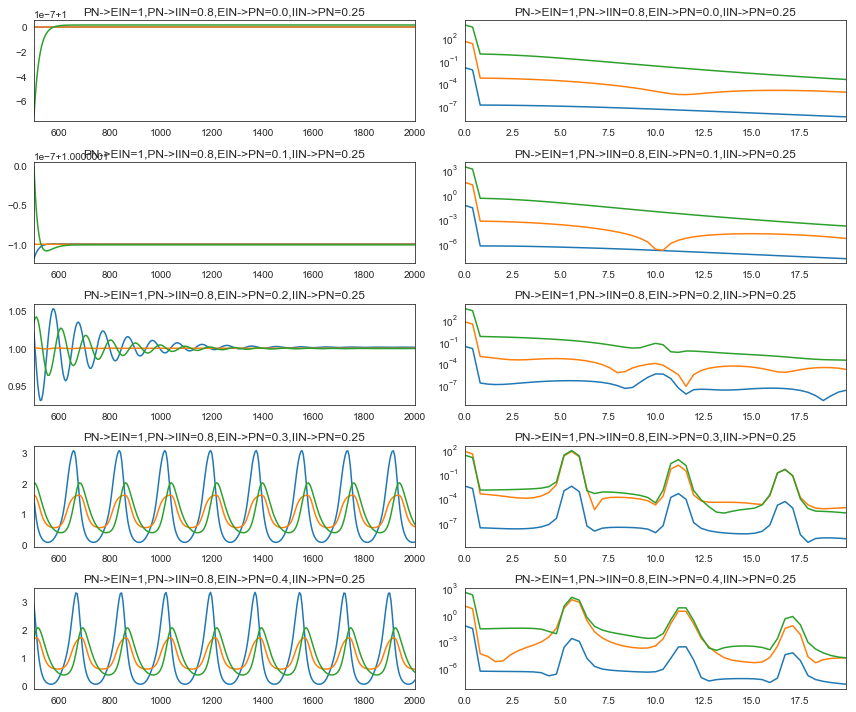

In [53]:
params =  [[1,0.8,0.0,0.25],
           [1,0.8,0.1,0.25],
           [1,0.8,0.2,0.25],
           [1,0.8,0.3,0.25],
           [1,0.8,0.4,0.25]]
                    
fig, ax = plt.subplots(nrows=len(params), ncols=2,figsize=(12,10))

for p_it,p in enumerate(params):
  p_arrs = [np.array([_p]) for _p in p ]
  a_1,a_2,a_3,a_4 = p_arrs

  jrm_params=dict(a_1=a_1,a_2=a_2,a_3=a_3,a_4=a_4)

  df_ys,df_ps = jrm_singlenode(jrm_params)

  a = ax[p_it][0]

  df_ys_norm = df_ys / df_ys.loc[500:1500].mean(axis=0)

  #df_ys[['cPN', 'cEIN', 'cIIN']].loc[500:2000].plot(legend=False,logy=False,ax=a)
  df_ys_norm[['cPN', 'cEIN', 'cIIN']].loc[500:2000].plot(legend=False,logy=False,ax=a)

  a.set_title('PN->EIN=%s,PN->IIN=%s,EIN->PN=%s,IIN->PN=%s' %(a_1[0],a_2[0],a_3[0],a_4[0]))

  a = ax[p_it][1]
  df_ps[['cPN', 'cEIN', 'cIIN']].loc[:20].plot(legend=False,logy=True,logx=False,ax=a)

  a.set_title('PN->EIN=%s,PN->IIN=%s,EIN->PN=%s,IIN->PN=%s' %(a_1[0],a_2[0],a_3[0],a_4[0]))


plt.tight_layout()

### The sigmoidal coupling function

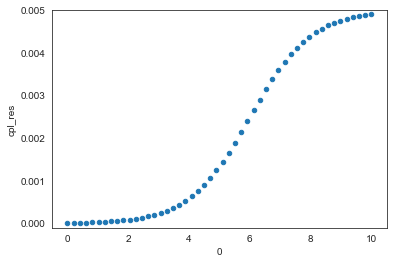

In [15]:
cpl = coupling.SigmoidalJansenRit()
cpl.configure()

inarr = np.linspace(0,10.,50).T
inarr = inarr[:,np.newaxis] 
inarr = np.concatenate([inarr, inarr],axis=1)
inarr[:,1] = 0

cpl_res = cpl.pre(_,inarr)

out_arr = pd.DataFrame(inarr)
out_arr['cpl_res'] = cpl_res

fig, ax = plt.subplots()
out_arr.plot(kind='scatter', x=0, y='cpl_res',ax=ax)

ax.set_ylim([-0.0001,0.005]);

## Network model of whole-brain anatomical connectivity


In connectome-based neural mass models, the anatomical connectivity is defined by a matrix of connection strengths (and, optionally, tract lengths or conduction delays). This matrix, in turn, is defined with respect to a *brain parcellation*: a categorical assignment of point locations in space to one or other brain region. 

In TVB, these are principally handled by the `connectivity` object. This contains the connectivity matrix (weights and tract lengths), as well as the list of labels and xyz centroid locations for the parcellation. 

In [16]:
conn = connectivity.Connectivity.from_file()
conn.configure()
conn

WARNING  File 'hemispheres' not found in ZIP.


,value
Number of connections,1560
Number of regions,76
Undirected,False
"areas [min, median, max]","[0, 2580.89, 10338.2]"
areas dtype,float64
areas shape,"(76,)"
"tract_lengths (connections) [min, median, max]","[0, 55.8574, 138.454]"
"tract_lengths [min, median, max]","[0, 71.6635, 153.486]"
"tract_lengths-non-zero [min, median, max]","[4.93328, 74.0646, 153.486]"
"weights [min, median, max]","[0, 0, 3]"


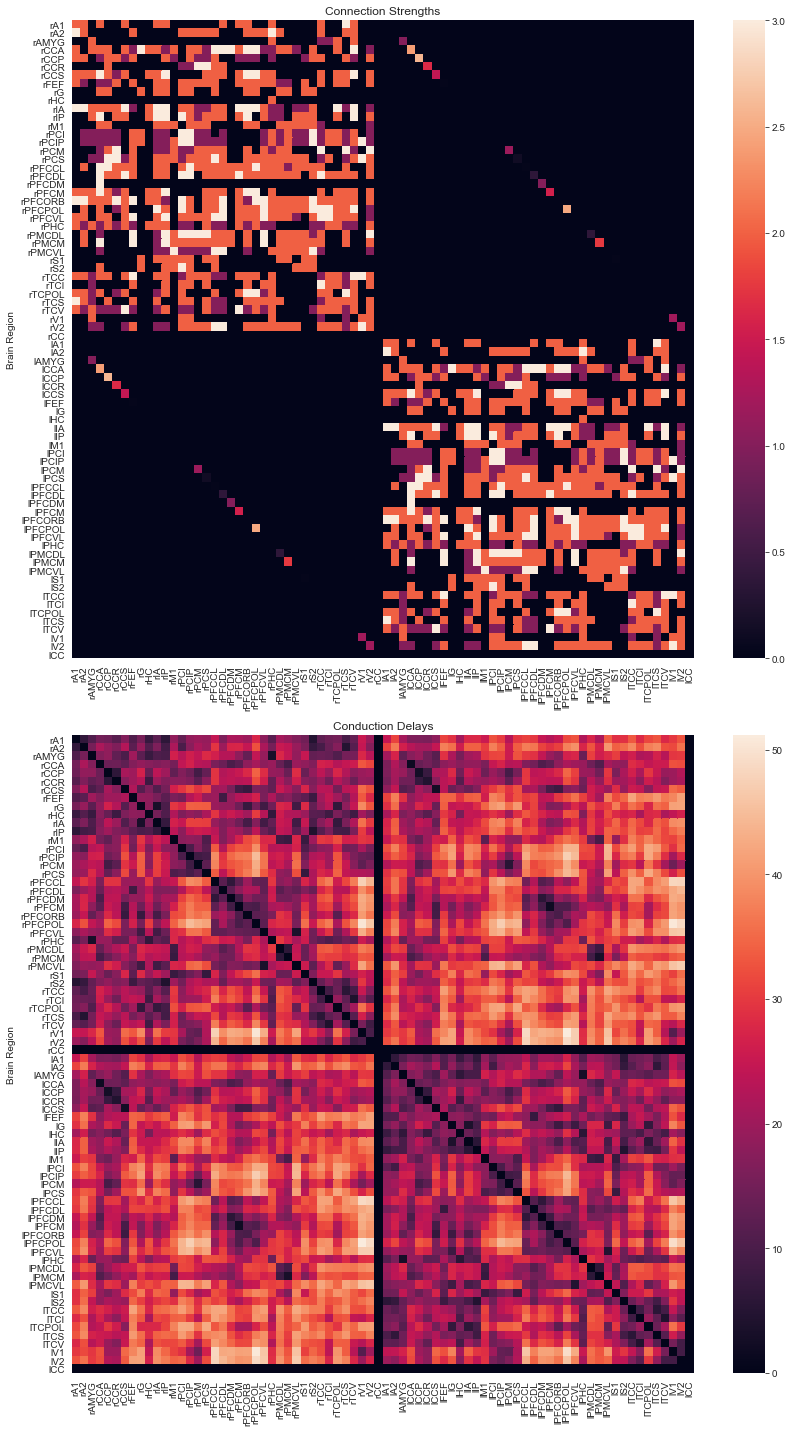

In [17]:
fig, ax = plt.subplots(nrows=2, figsize=(12,20))

a = ax[0]
sns.heatmap(conn.weights, ax=a,
            xticklabels=conn.region_labels,yticklabels=conn.region_labels)
a.set_title('Connection Strengths')
a.set_ylabel('Brain Region')


a = ax[1]
sns.heatmap(conn.delays, ax=a,
            xticklabels=conn.region_labels,yticklabels=conn.region_labels)
a.set_title('Conduction Delays')
a.set_ylabel('Brain Region')


plt.tight_layout()

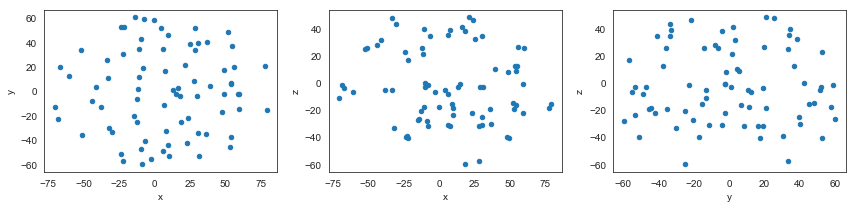

In [18]:
df_centres = pd.DataFrame(conn.centres,columns=['x', 'y', 'z'])

fig, ax = plt.subplots(ncols=3, figsize=(12,3))

df_centres.plot(kind='scatter', x='x', y='y', ax=ax[0])
df_centres.plot(kind='scatter', x='x', y='z', ax=ax[1])
df_centres.plot(kind='scatter', x='y', y='z', ax=ax[2])

#fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
#ax.scatter(df_centres.x,df_centres.y,df_centres.z)

plt.tight_layout()


In addition to the xyz point locations, we can also use the associated brain surface to visualize brain parcels in cortical regions, as well as patterns of variation over the cortex in regional properties. 

This is done using a *surface mesh* and a *region mapping*, that assigns each point on the surface (each surface *vertex*) to a brain parcel.

In [19]:
surf = surfaces.CorticalSurface.from_file()#load_default=True)
vtx = surf.vertices
tri = surf.triangles

regmap = region_mapping.RegionMapping.from_file().array_data
isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
isrh_vtx = np.array([isrh_reg[r] for r in regmap])

reg_idxs = np.arange(0,conn.region_labels.shape[0])

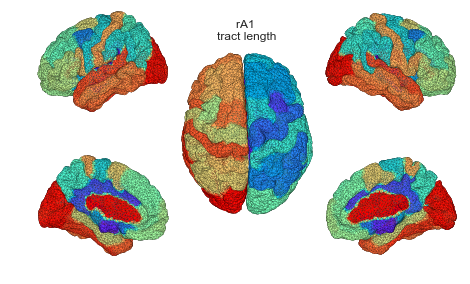

In [20]:
plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=regmap,data=reg_idxs,
                    hemi=isrh_vtx,title=u'rA1 \ntract length',
                    shade_kwargs = {'shading': 'flat',
                                    'cmap': 'rainbow',
                                    'edgecolors': 'black', 
                                    'linewidth': 0.1},
                    figsize=(30,30))

As an aside: we're using a custom matplotlib function for these surface plots, but they can also be done more simply using `nilearn`'s in-built surface plotting tools.

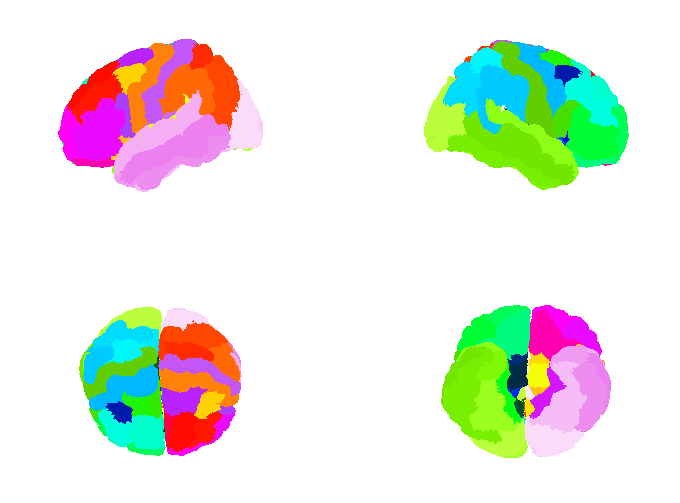

In [21]:
# (note: the TVB surface is not in the same alignment as freesurfer surfaces, so the orientations are off)

fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(12,9),subplot_kw={'projection': '3d'})

a = ax[0][0]
disp = plot_surf_roi([surf.vertices,surf.triangles],regmap, view='anterior', hemi='left',axes=a)

a = ax[0][1]
disp = plot_surf_roi([surf.vertices,surf.triangles],regmap, view='posterior', hemi='left',axes=a)

a = ax[1][0]
disp = plot_surf_roi([surf.vertices,surf.triangles],regmap, view='dorsal', hemi='left',axes=a)

a = ax[1][1]
disp = plot_surf_roi([surf.vertices,surf.triangles],regmap, view='ventral', hemi='right',axes=a)

The numbers in the connectivity matrix can be plotted directly on the cortical surface using the region mapping

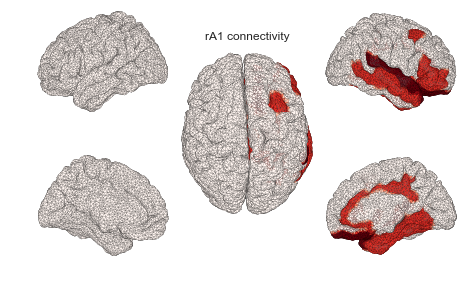

In [22]:
conn_rA1 = conn.weights[:,0]
#conn_rV1 = conn.weights[:,35]

plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=regmap,data=conn_rA1,
                    hemi=isrh_vtx,title=u'rA1 connectivity',
                    shade_kwargs = {'shading': 'flat',
                                    'cmap': 'Reds',
                                    'edgecolors': 'black', 
                                    'linewidth': 0.1,
                                    'vmin':0,'vmax':3},
                    figsize=(30,30))

## Simulating whole-brain neural activity 

Whole-brain simulation function

In [23]:
def jrmsim(simlength = 1000., do_stim = False,tavg_per=0.5,eeg_per=0.5,conn=None,sigma=None,
           jrm_params=None,cpl_type='linear', cpl_params=None,int_dt=0.5,do_eeg=True,speed=3.):

    # Define the connectivity
    if conn is None:
      #normalising connectivity and setting delay to 0
      conn = connectivity.Connectivity.from_file()#(load_default=True)
      conn.speed = np.array([speed]) 
      conn.configure()
      w_orig = conn.weights.copy()
      w_norm = (w_orig.T / w_orig.sum(axis=1) ).T
      w_norm[np.isnan(w_norm)] = 0
      #conn.weights = w_norm*22
      #conn.delays *= 0

    # Define the model
    if jrm_params is None:
      jrm_params = dict(v0=np.array([6.]))
    jrm = models.JansenRit(**jrm_params) #the only non-default variable
    
    # Set the noise
    if sigma is None:
        phi_n_scaling = (jrm.a * jrm.A * (jrm.p_max-jrm.p_min) * 0.5 )**2 / 2.
        sigma         = np.zeros(6)
        sigma[3]      = phi_n_scaling *1e-5 #shrank noise by 1e-5
    
    # Define a stimulus
    if do_stim == False:
        stimulus = None
    else:
        eqn_t = equations.PulseTrain()
        eqn_t.parameters['onset'] = 0.
        eqn_t.parameters['T'] = 108.5
        eqn_t.parameters['tau'] = 135000
        eqn_t.parameters['amp'] = .4

        weighting = stim_weight

        stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                        connectivity=conn,
                                        weight=weighting)
        
    # Define the coupling
    if cpl_params == None: cpl_params = {}
    if cpl_type == 'jansen_rit':
        cpl = coupling.SigmoidalJansenRit(**cpl_params)
    elif cpl_type == 'linear':
        cpl = coupling.Linear(**cpl_params)

    # Set up the integration scheme
    solver = integrators.HeunStochastic(dt=int_dt,noise=noise.Additive(nsig=sigma)) #integrator dt is bottleneck
        
    # Set up the monitors
    if do_eeg is True:
        eeg_mon = monitors.EEG.from_file()
        eeg_mon.period = eeg_per
        tavg_mon = monitors.TemporalAverage()
        tavg_mon.period = tavg_per
        mons=(tavg_mon,eeg_mon,)
    else:
        mons=(monitors.TemporalAverage(period=tavg_per),)
    
    # Create the simulator object
    sim = simulator.Simulator(
        model=jrm,
        connectivity=conn,
        coupling=cpl,
        integrator=solver,
        simulation_length=simlength,
        monitors=mons,
        stimulus=stimulus
    ).configure()


    # Run the sim and put results into dataframes

    (tavg_time, tavg_data),(eeg_time,eeg_data) = sim.run()

    df_cPN = pd.DataFrame(np.squeeze(tavg_data[:,0,:,0]),index=tavg_time)
    df_cPN.index.names = ['t']
    df_cPN.columns.names = ['region']

    df_cEIN = pd.DataFrame(np.squeeze(tavg_data[:,1,:,0]),index=tavg_time)
    df_cEIN.index.names = ['t']
    df_cEIN.columns.names = ['region']

    df_cIIN = pd.DataFrame(np.squeeze(tavg_data[:,2,:,0]),index=tavg_time)
    df_cIIN.index.names = ['t']
    df_cIIN.columns.names = ['region']

    df_vPN =  pd.DataFrame(np.squeeze(tavg_data[:,3,:,0]),index=tavg_time)
    df_vPN.index.names = ['t']
    df_vPN.columns.names = ['region']

    
    df_eeg = pd.DataFrame(np.squeeze(eeg_data[:,0,:,0]),index=eeg_time)
    df_eeg.index.names = ['t']
    df_eeg.columns.names = ['chan']

    # Compute power spectrum

    freqs,ps_cPN = welch(df_cPN.values.T,fs=1000/tavg_per, noverlap = 0, nperseg=16000)
    df_ps_cPN = pd.DataFrame(ps_cPN.T,index=freqs)

    freqs,ps_cEIN = welch(df_cEIN.values.T,fs=1000/tavg_per, noverlap = 0, nperseg=16000)
    df_ps_cEIN = pd.DataFrame(ps_cEIN.T,index=freqs)

    freqs,ps_cIIN = welch(df_cIIN.values.T,fs=1000/tavg_per, noverlap = 0, nperseg=16000)
    df_ps_cIIN = pd.DataFrame(ps_cIIN.T,index=freqs)

    freqs,ps_vPN = welch(df_vPN.values.T,fs=1000/tavg_per, noverlap = 0, nperseg=16000)
    df_ps_vPN = pd.DataFrame(ps_vPN.T,index=freqs)

    freqs,ps_eeg = welch(df_eeg.values.T,fs=1000/eeg_per, noverlap = 0, nperseg=16000)
    df_ps_eeg = pd.DataFrame(ps_eeg.T,index=freqs)

    

    return (df_cPN,df_cEIN, df_cIIN, df_vPN, df_eeg,
            df_ps_cPN,df_ps_cEIN,df_ps_cIIN,df_ps_vPN, df_ps_eeg)

In [24]:
def get_fooof_params(df,freq_range = [0,50]):

    df_norm = df / df.sum(axis=0)

    powr = df_norm.loc[freq_range[0]:freq_range[1]].values.T
    freqs = df_norm.loc[freq_range[0]:freq_range[1]].index.values

    all_fooofers = []
    all_pps = []
    for p in powr[:,:]:
        thisfooofer = FOOOF(max_n_peaks=1)
        thisfooofer.fit(power_spectrum=p,freqs=freqs,freq_range=[0,50])
    
        all_fooofers.append(thisfooofer)
    
        pps = np.squeeze(thisfooofer.peak_params_)
    
        if pps.shape[0] == 0:
            pps = np.zeros(3)
        all_pps.append(pps)


    all_pps_arr = np.array(all_pps)

    df_all_pps = pd.DataFrame(all_pps_arr)

    
    
    clear_output()
    
    return df_all_pps

Run whole brain sims

In [93]:
%%time

cpl_params = dict(a=0.0005)
cpl_params = {k: np.array(v) for k,v in cpl_params.items()}

jrm_params = dict(v0=6.,a_1=1,a_2=0.8,a_3=0.6,a_4=0.25)
jrm_params = {k: np.array([v]) for k,v in jrm_params.items()}

res = jrmsim(simlength=10000,cpl_type='linear', cpl_params=cpl_params,jrm_params=jrm_params,int_dt=0.2,sigma=None)
df_cPN,df_cEIN, df_cIIN, df_vPN,df_eeg,df_ps_cPN,df_ps_cEIN,df_ps_cIIN,df_ps_vPN,df_ps_eeg = res

WARNING  File 'hemispheres' not found in ZIP.
   INFO  Projection configured gain shape (65, 76)
Wall time: 34.5 s


Text(0.5, 1.0, 'Functional connectivity')

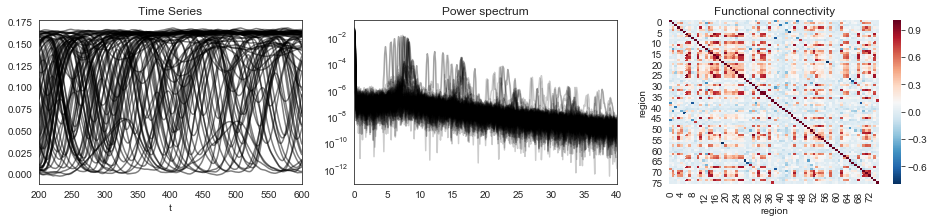

In [94]:
fig, ax = plt.subplots(ncols=3, figsize=(16,3))

a = ax[0]
df_cPN.loc[200:600].plot(ax=a,legend=False,alpha=0.5,c='k')
a.set_title('Time Series')

a = ax[1]
df_ps_cPN.loc[:40].plot(ax=a,logx=False,logy=True,legend=False,alpha=0.2,c='k')
a.set_title('Power spectrum')

a = ax[2]                         
sns.heatmap(df_cPN.loc[200:].corr(),ax=a,cmap='RdBu_r')
a.set_title('Functional connectivity')

Wall time: 1.56 s


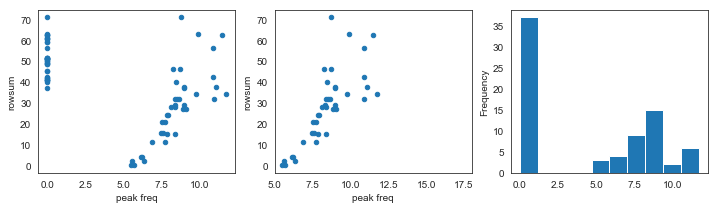

In [95]:
%%time
df_ps_cPN_fooof = get_fooof_params(df_ps_cPN)
df_pps_vs_sumweights = pd.DataFrame(np.concatenate([df_ps_cPN_fooof[0].values[:,np.newaxis],
                                                    conn.weights.sum(axis=1)[:,np.newaxis] ] ,axis=1))
df_pps_vs_sumweights.columns = ['peak freq', 'rowsum']


fig, ax  = plt.subplots(ncols=3, figsize=(12,3))

df_pps_vs_sumweights.dropna().plot(kind='scatter', x='peak freq', y='rowsum',ax=ax[0])
df_pps_vs_sumweights.dropna().plot(kind='scatter', x='peak freq', y='rowsum',ax=ax[1])
ax[1].set_xlim([5,18])

df_ps_cPN_fooof[0].plot(kind='hist',ax=ax[2])

---


## References


> Jansen, B.H. and Rit, V.G. (1995) **Electroencephalogram and visual evoked potential generation in a mathematical model of coupled cortical columns.** *Biological cybernetics*, 73(4), pp.357-366.    

> Da Silva, F.L., Hoeks, A., Smits, H. and Zetterberg, L.H. (1974). **Model of brain rhythmic activity.** *Kybernetik*, 15(1), pp.27-37.  

> David, O. and Friston, K.J. (2003) **A neural mass model for MEG/EEG: coupling and neuronal dynamics.** *NeuroImage*, 20(3), pp.1743-1755.  

> Spiegler, A., Knösche, T.R., Schwab, K., Haueisen, J. and Atay, F.M. (2011). **Modeling brain resonance phenomena using a neural mass model.** *PLoS Comput Biol*, 7(12), p.e1002298.

> Sanz-Leon, P., Knock, S.A., Spiegler, A. and Jirsa, V.K. (2015). **Mathematical framework for large-scale brain network modeling in The Virtual Brain.** *Neuroimage*, 111, pp.385-430.  
